# Módulos

In [8]:
import os # Sistema (arquivos)
import pandas as pd # Tabelas
import sqlite3 # SQL

from datetime import datetime # Datas

import matplotlib.pyplot as plt # Gráficos

import random # Amostragem aleatória
from IPython.display import HTML # Visualização em HTML no Jupyter

# Releitura e compactação

In [12]:
%%time
# Releitura

htmls_SQL = []
for arquivo in os.listdir('bases/SQLs'):
    conn = sqlite3.connect(f'bases/SQLs/{arquivo}')
    htmls_SQL.append(pd.read_sql('SELECT * FROM htmls', conn))
    del conn
htmls_SQL = pd.concat(htmls_SQL, ignore_index = True)


# Tratamentos

htmls_SQL.data_do_html = pd.to_datetime(htmls_SQL.data_do_html.str.slice(0, 19), format = 'ISO8601')
htmls_SQL = htmls_SQL.map(lambda x: None if x == '' else x) # Tornando os textos vazios em NaN.
htmls_SQL.dropna(subset = ['data_do_html', 'resumo', 'conteúdo'], how = 'all', inplace = True) # Sem dados.
htmls_SQL.drop_duplicates(subset = ['url', 'data_do_html', 'resumo', 'conteúdo'], inplace = True) # Duplicados.
htmls_SQL = htmls_SQL.copy()[~htmls_SQL.manchete.str.contains(r'Error|^Ops!$')] # Leu, mas leu errado. Cortando tudo!

CPU times: total: 30.8 s
Wall time: 31.2 s


In [13]:
%%time
htmls_SQL.to_parquet('bases/htmls.parquet', engine = 'pyarrow', index = False)

CPU times: total: 20 s
Wall time: 20.3 s


# Vistoria

In [282]:
%%time
htmls_SQL = pd.read_parquet('bases/htmls.parquet')
htmls_SQL['portal'] = htmls_SQL.url.apply(lambda url: url.split('/')[2].split('.')[0]).replace('revistagloborural', 'globorural')

CPU times: total: 15.2 s
Wall time: 13.1 s


## Sucesso na captação

In [283]:
diretório = os.getcwd() # Diretório atual e sua raíz imediata:
diretório_anterior = '\\'.join(diretório.split('\\')[:-1])

In [6]:
urls_SQL = pd.read_parquet(f'{diretório_anterior}\\urls\\bases\\urls.parquet')
portais = urls_SQL.groupby(by = ['portal'])
frequência_de_urls = portais.count()[['url']].sort_values(by = 'url', ascending = False)
frequência_de_urls.columns = ['nº de urls']

portais = htmls_SQL.groupby(by = ['portal'])
frequência_de_htmls = portais.count()[['url']].sort_values(by = 'url', ascending = False)
frequência_de_htmls.columns = ['nº de htmls']

frequências = pd.concat([frequência_de_urls, frequência_de_htmls], axis = 1).fillna(0).astype(int)
frequências.loc['total'] = frequências.sum()

frequências['% de captação'] = (100*(frequências['nº de htmls'] / frequências['nº de urls'])).apply(lambda x: f'{x:.2f}%')
frequências[['nº de urls', 'nº de htmls']] = frequências[['nº de urls', 'nº de htmls']].map(lambda x: f'{x:,}'.replace(',','.'))
frequências

,nº de urls,nº de htmls,% de captação
portal,,,
valor,822.560,821.520,99.87%
epocanegocios,195.211,194.469,99.62%
valorinveste,85.225,84.720,99.41%
revistapegn,76.253,75.876,99.51%
globorural,57.900,57.619,99.51%
umsoplaneta,13.165,13.153,99.91%
pipelinevalor,4.643,4.643,100.00%
total,1.254.957,1.252.000,99.76%


## Frequência no tempo

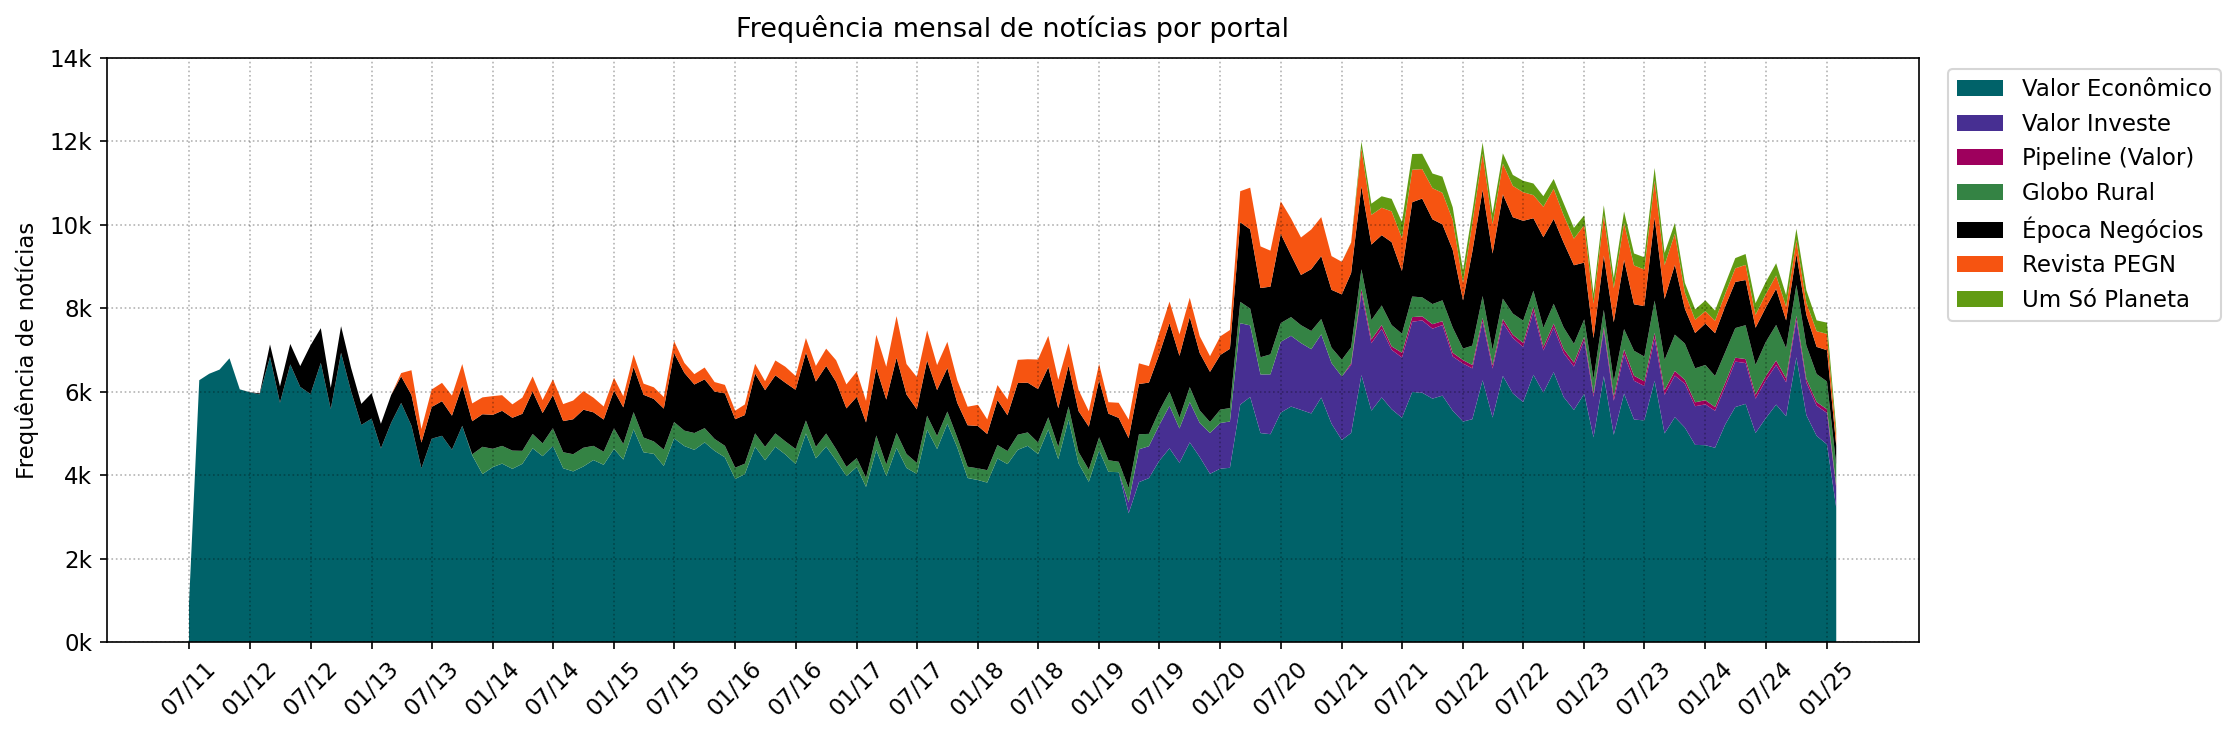

In [18]:
portais = htmls_SQL.groupby(['portal', 'data_do_html']).count().url.unstack().fillna(0)

portais = portais.T
portais.index = pd.to_datetime(portais.index)
portais = portais.resample('ME').sum()  # Agrupando por mês
portais = portais['valor valorinveste pipelinevalor globorural epocanegocios revistapegn umsoplaneta'.split()]

colors = [(0/255, 98/255, 105/255), # valor
          (71/255, 47/255, 146/255), # valorinveste
          (158/255, 0/255, 93/255), # pipelinevalor
          (52/255, 131/255, 68/255), # globorural
          (0/255, 0/255, 0/255), # epocanegocios
          (246/255, 84/255, 17/255), # revistapegn
          (97/255, 155/255, 19/255)] # umsoplaneta

nomes = ['Valor Econômico',
         'Valor Investe',
         'Pipeline (Valor)',
         'Globo Rural',
         'Época Negócios',
         'Revista PEGN',
         'Um Só Planeta']

fig, ax = plt.subplots(figsize = (15, 5), dpi = 150)
ax.stackplot(portais.index, portais.T, colors = colors, labels = nomes)

ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=11)
ax.set_title("Frequência mensal de notícias por portal", pad = 10, fontsize = 13)

plt.grid(linestyle = ':', color = 'black', alpha = .3)

plt.ylabel('Frequência de notícias', fontsize = 11, labelpad = 5)
yticks = plt.yticks()[0]
plt.yticks(yticks, list(map(lambda y: f'{y/1000:.0f}k', yticks)), fontsize = 11)

indices_semestrais = portais.index[::6]
rotulos_semestrais = [f"{dt.month:02d}/{dt.year % 100:02d}" for dt in indices_semestrais]
plt.xticks(indices_semestrais, rotulos_semestrais, rotation = 45, fontsize = 11)

plt.tight_layout()
plt.show()

# Inspeção no Valor Econômico

In [19]:
htmls_valor = htmls_SQL[htmls_SQL.url.str.contains('/valor.globo.com')]
print(f'{htmls_valor.shape[0]/6300:.2f}% raspados!')

130.40% raspados!


In [27]:
data, manchete, resumo, conteúdo, url, portal = htmls_valor.iloc[random.randint(0, len(htmls_valor))].fillna('').values.tolist()
conteúdo = '</p><p>'.join(conteúdo.split(' /// ')).replace('$', '\\$')
display(HTML(f'<h1>{manchete}</h1><hr><a href="{url}">{url}</a><p>{data}</p><p><b>{resumo}</b><hr></p><p>{conteúdo}</p>'))

In [28]:
pd.concat([pd.DataFrame(htmls_valor.isna().sum(), columns = ['nº de nulos']).T,
           pd.DataFrame(((100*htmls_valor.isna().sum()/len(htmls_valor)).round(2)).astype(str)+'%', columns = ['% de nulos']).T])

,data_do_html,manchete,resumo,conteúdo,url,portal
nº de nulos,206,0,502580,3181,0,0
% de nulos,0.03%,0.0%,61.18%,0.39%,0.0%,0.0%


In [29]:
sem_conteúdo_na_valor = htmls_valor[htmls_valor.conteúdo.isna()].copy()
sem_conteúdo_na_valor

,data_do_html,manchete,resumo,conteúdo,url,portal
1035908,2011-07-25 20:04:14,Investimento cresce menos que outros grupos de...,None,None,https://valor.globo.com/brasil/noticia/2011/07...,valor
1035909,2011-07-25 19:09:27,Investimento cresce menos que outros grupos de...,None,None,https://valor.globo.com/brasil/noticia/2011/07...,valor
1035954,2011-07-28 17:15:57,MPF em Guarulhos pede multa para empresas aére...,None,None,https://valor.globo.com/brasil/noticia/2011/07...,valor
1035955,2011-07-28 15:22:48,Paulista se inspira em Hitchcock para exposiçã...,None,None,https://valor.globo.com/eu-e/noticia/2011/07/2...,valor
1035956,2011-07-28 14:59:05,Fiesp revisa para baixo produtividade da indús...,None,None,https://valor.globo.com/brasil/noticia/2011/07...,valor
...,...,...,...,...,...,...
1167264,2011-07-26 12:44:31,"Febraban vê desaceleração do crédito, mas ritm...",None,None,https://valor.globo.com/brasil/noticia/2011/07...,valor
1167266,2011-07-26 10:22:57,Estrangeiro abraça renda fixa e novas equipes ...,None,None,https://valor.globo.com/financas/casa-das-cald...,valor
1167267,2011-07-26 09:41:07,"Resultado na meta; nada mais, nada menos",None,None,https://valor.globo.com/financas/casa-das-cald...,valor
1167278,2011-07-25 15:29:09,O outro lado da celebridade,None,None,https://valor.globo.com/politica/noticia/2011/...,valor


In [30]:
sem_conteúdo_na_valor.url.tolist()

['https://valor.globo.com/brasil/noticia/2011/07/25/investimento-cresce-menos-que-outros-grupos-de-despesas-no-semestre.ghtml',
 'https://valor.globo.com/brasil/noticia/2011/07/25/investimento-cresce-menos-que-outros-grupos-de-despesas-no-semestre-1.ghtml',
 'https://valor.globo.com/brasil/noticia/2011/07/28/mpf-em-guarulhos-pede-multa-para-empresas-aereas-por-overbooking.ghtml',
 'https://valor.globo.com/eu-e/noticia/2011/07/28/paulista-se-inspira-em-hitchcock-para-exposicao-francesa-no-rio.ghtml',
 'https://valor.globo.com/brasil/noticia/2011/07/28/fiesp-revisa-para-baixo-produtividade-da-industria-paulista.ghtml',
 'https://valor.globo.com/eu-e/noticia/2011/07/29/origami-cultural-busca-lacuna-no-mercado.ghtml',
 'https://valor.globo.com/empresas/noticia/2011/07/28/brasil-lidera-crescimento-do-transporte-aereo-domestico-no-ano.ghtml',
 'https://valor.globo.com/brasil/noticia/2011/07/29/centrais-recusam-convite-para-conhecer-nova-politica-industrial.ghtml',
 'https://valor.globo.com/b

# Inspeção de dados ausentes

In [31]:
nulos_sem_ao_vivo = htmls_SQL[~htmls_SQL.url.str.contains('/ao-vivo/')]
pd.concat([pd.DataFrame(nulos_sem_ao_vivo.isna().sum(), columns = ['nº de nulos']).T,
           pd.DataFrame(((100*nulos_sem_ao_vivo.isna().sum()/len(nulos_sem_ao_vivo)).round(2)).astype(str)+'%', columns = ['% de nulos']).T])

,data_do_html,manchete,resumo,conteúdo,url,portal
nº de nulos,112,0,504370,3717,0,0
% de nulos,0.01%,0.0%,40.34%,0.3%,0.0%,0.0%


## Ops!

In [32]:
nulos_sem_ao_vivo_e_sem_ops = nulos_sem_ao_vivo[~nulos_sem_ao_vivo.manchete.str.contains('Ops!')]
ops = htmls_SQL[htmls_SQL.manchete.str.contains('Ops!')]
print(len(ops))
ops

1


,data_do_html,manchete,resumo,conteúdo,url,portal
20739,2023-05-10 13:20:20,Ops! Google vaza seu próprio anúncio do smartp...,Vídeo do YouTube continha várias fotos do disp...,Os amantes da tecnologia estão ansiosos pelo e...,https://epocanegocios.globo.com/tecnologia/not...,epocanegocios


## Data

In [35]:
nulos = nulos_sem_ao_vivo_e_sem_ops[nulos_sem_ao_vivo_e_sem_ops.data_do_html.isna()]
data, manchete, resumo, conteúdo, url, portal = nulos.iloc[random.randint(0, len(nulos)-1)].fillna('').values.tolist()
conteúdo = '</p><p>'.join(conteúdo.split(' /// '))
display(HTML(f'<h1>{manchete}</h1><hr><a href="{url}">{url}</a><p>{data}</p><p><b>{resumo}</b><hr></p><p>{conteúdo}</p>'))

## Resumo

In [36]:
nulos = nulos_sem_ao_vivo_e_sem_ops[nulos_sem_ao_vivo_e_sem_ops.resumo.isna()]
data, manchete, resumo, conteúdo, url, portal = nulos.iloc[random.randint(0, len(nulos)-1)].fillna('').values.tolist()
conteúdo = '</p><p>'.join(conteúdo.split(' /// '))
display(HTML(f'<h1>{manchete}</h1><hr><a href="{url}">{url}</a><p>{data}</p><p><b>{resumo}</b><hr></p><p>{conteúdo}</p>'))

## Conteúdo

In [39]:
nulos = nulos_sem_ao_vivo[nulos_sem_ao_vivo.conteúdo.isna()]
data, manchete, resumo, conteúdo, url, portal = nulos.iloc[random.randint(0, len(nulos)-1)].fillna('').values.tolist()
conteúdo = '</p><p>'.join(conteúdo.split(' /// '))
display(HTML(f'<h1>{manchete}</h1><hr><a href="{url}">{url}</a><p>{data}</p><p><b>{resumo}</b><hr></p><p>{conteúdo}</p>'))

# Amostragem aleatória

In [281]:
data, manchete, resumo, conteúdo, url, portal = htmls_SQL.iloc[random.randint(0, len(htmls_SQL))].fillna('').values.tolist()
conteúdo = '</p><p>'.join(conteúdo.split(' /// ')).replace('$', '\\$')
display(HTML(f'<h1>{manchete}</h1><hr><a href="{url}">{url}</a><p>{data}</p><p><b>{resumo}</b><hr></p><p>{conteúdo}</p>'))